<a href="https://colab.research.google.com/github/andygoosh/sibur2019/blob/master/Polypropylene_NN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%pylab inline
plt.style.use("bmh")

plt.rcParams["figure.figsize"] = (6,6)

import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import json
import tqdm
import pathlib

RS = 77
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

TensorFlow 2.x selected.
Populating the interactive namespace from numpy and matplotlib


In [0]:
train_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/1751c781501264f1f49537054f901dc2/activity_train.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip", dtype=np.float32)
test_data = pd.read_csv("https://sibur.ai-community.com/files/uploads/511e69d37295aabf89fc0cce5e8a2de5/activity_test.csv.zip",
                         parse_dates=["date"], index_col="date",
                         compression="zip", dtype=np.float32)
activity_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")
atactic_test_target = pd.read_csv("https://sibur.ai-community.com/files/uploads/9bef2749c625cf89373bcb4861962c14/activity_test_timestamps.csv",
                         parse_dates=["date"], index_col="date")

In [0]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [0]:
data.drop(['f28'], axis=1, inplace=True)
full_data = data

In [0]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

FTS_COLS = activity_data.columns[1:]
TARGET = "activity"

In [6]:
activity_data

,activity,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-13 14:30:00,32.449894,49.048771,294.933258,1.675466,0.000051,0.024688,0.001628,1724179.875,728860.1875,1.179884,0.513442,1.681574,0.00005,0.024943,0.001629,758645.0625,1.187274,0.558392,343.170532,343.145630,343.111053,1.574781,1.615477,0.009761,0.009680,301.923309,0.484171,0.557710,0.233514,195.594421,145.390152,123.790154,66.654694,72.028564,68.728233,64130.855469,151915.828125,144110.187500,343.259705,343.342224,343.298920,343.352264,255.800003,101038.078125,77.000000,343.135590,335.675781,335.746246,336.916199,336.979767,342.956055,332.808258,332.816650,5493.317871,4829.338867,521.341003
2018-02-13 14:31:00,26.492102,49.007980,294.932861,1.675090,0.000051,0.024659,0.001633,1724522.625,729611.8125,1.179814,0.513436,1.681415,0.00005,0.024994,0.001625,761764.5625,1.187331,0.558663,343.152740,343.151733,343.113586,1.573941,1.612820,0.009769,0.009681,301.906158,0.484099,0.557320,0.233740,195.485733,145.428085,123.800293,66.707825,71.945526,68.780815,64179.140625,151867.468750,144171.921875,343.257507,343.338104,343.312317,343.343262,255.799438,101038.296875,76.988892,343.138062,335.665405,335.737335,336.983887,337.029785,342.971741,332.822632,332.781982,5247.641113,5020.168945,520.791870
2018-02-13 14:32:00,34.102711,48.994400,294.932709,1.675766,0.000051,0.024727,0.001639,1724581.750,730361.8125,1.179867,0.513290,1.681492,0.00005,0.024928,0.001629,759461.1250,1.187246,0.558563,343.154266,343.159851,343.116638,1.573461,1.614684,0.009792,0.009695,301.929932,0.483961,0.557615,0.233675,195.580826,145.386292,124.295151,66.758423,71.957291,68.759193,64251.503906,152158.968750,144231.218750,343.254852,343.341431,343.326996,343.342194,255.798889,101038.523438,76.977776,343.132507,335.630951,335.700500,336.979126,337.051575,342.973816,332.841644,332.829620,5000.878906,5207.399902,520.242798
2018-02-13 14:33:00,41.518223,48.970760,294.936981,1.675868,0.000051,0.024723,0.001641,1724676.625,730486.0625,1.186719,0.511677,1.681643,0.00005,0.024922,0.001629,760412.2500,1.187280,0.558469,343.150208,343.167999,343.117645,1.573785,1.613456,0.009796,0.009700,301.905670,0.483804,0.557747,0.234117,195.337006,145.523590,124.203743,66.790413,72.011253,68.779694,64292.312500,152426.296875,144232.437500,343.262054,343.345398,343.325134,343.350372,255.798340,101038.742188,76.966667,343.152283,335.576538,335.655334,337.009949,337.052795,342.979431,332.882721,332.886810,4751.941406,5387.604004,521.320496
2018-02-13 14:34:00,38.896862,48.952991,294.935394,1.675002,0.000051,0.024708,0.001646,1724621.000,730061.5625,1.186838,0.511305,1.681514,0.00005,0.025069,0.001633,758510.9375,1.187319,0.558569,343.153259,343.163940,343.122223,1.574134,1.615544,0.009814,0.009702,301.929047,0.483762,0.557368,0.234114,195.578384,145.655548,123.860565,66.786430,71.998047,68.740585,64244.835938,152378.906250,144174.015625,343.265503,343.343353,343.333710,343.342865,255.797775,101038.968750,76.955559,343.136475,335.539764,335.637482,337.050049,337.107635,342.987213,332.912567,332.905762,4513.198730,5566.278809,522.398132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 22:03:00,47.456123,70.499237,295.062500,1.633432,0.000052,0.020063,0.001865,1714337.125,725372.7500,2.815988,0.598451,1.644489,0.00005,0.021988,0.001884,710868.0625,3.082910,0.630432,343.155273,343.141541,343.145630,1.550223,1.569349,0.008697,0.008775,256.154663,0.594300,0.613581,0.254711,189.814789,142.995667,127.102386,67.670166,71.255936,71.865143,70639.203125,152824.765625,149946.125000,343.257843,343.380737,343.374786,343.361755,261.019

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 70)                3920      
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3053      
_________________________________________________________________
dropout_1 (Dropout)          (None, 43)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                704       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 6

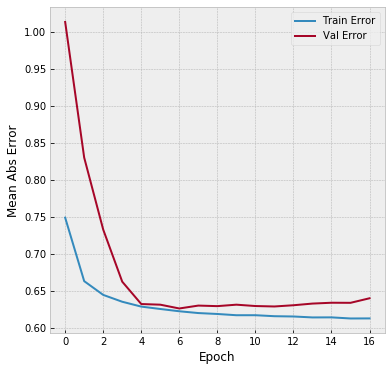

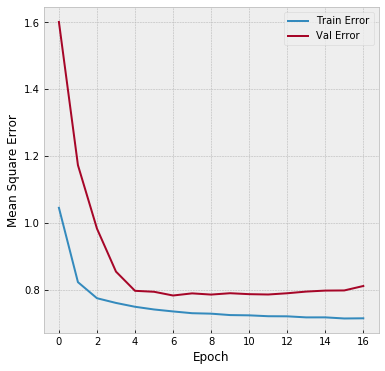

MAPE (training set): 9.95%
MAPE (cross-validation set): 8.90%


In [7]:
##### 0D model #####
tf.keras.backend.clear_session()

EPOCHS = 500
BS = 512

tr_data = activity_data[:"2018-10-13"].copy()
cv_data = activity_data["2018-10-14":].copy()

center, scale = tr_data[FTS_COLS].mean().values, tr_data[FTS_COLS].std().values
trn = (tr_data[FTS_COLS].values - center)/scale
cvn = (cv_data[FTS_COLS].values - center)/scale

#y_trn = sig.savgol_filter(tr_data.activity.values, 91, 1) 
y_trn = tr_data[TARGET].values
#y_cv =  sig.savgol_filter(cv_data.activity.values, 91, 1)
y_cv =  cv_data[TARGET].values

model = keras.Sequential([
      layers.Input(shape=len(FTS_COLS)),
      layers.Dense(70),
      layers.Dropout(0.4),
      layers.Dense(43, activation='relu'),
      layers.Dropout(0.3),
      layers.Dense(16),
      layers.Dropout(0.1),
      layers.Dense(4),
      layers.Dense(1)
    ])
model.compile(optimizer='adam', metrics=['mae', 'mse'], loss='mse')

model.reset_states()
model.summary()

history = model.fit(trn, (y_trn - y_trn.mean())/y_trn.std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=0,
          validation_data=(cvn, (y_cv - y_trn.mean())/y_trn.std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
          keras.callbacks.ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True ) 
          ])
model = tf.keras.models.load_model('my_checkpoint.h5')

plot_history(history)

tr_preds = model.predict(trn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()
cv_preds = model.predict(cvn, use_multiprocessing=True) * y_trn.std() + y_trn.mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

print(f"MAPE (training set): {100 * mape(tr_data.activity.values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data.activity.values, cv_preds.values):.2f}%")


(737036.0, 737043.75)

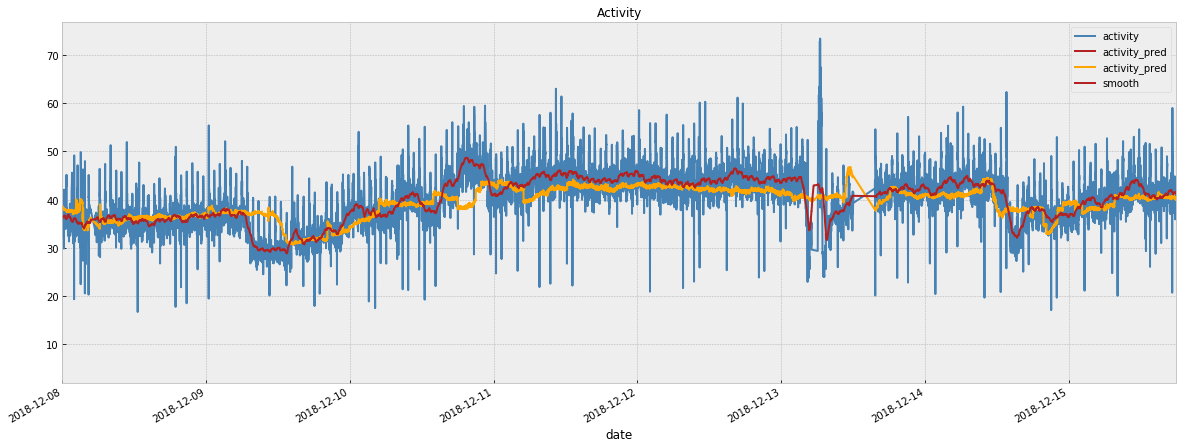

In [8]:
import scipy.signal as sig

plt.rcParams['figure.figsize'] = (16, 6)

tr_data["activity"].plot(ax=plt.gca(), c="steelblue")
cv_data["activity"].plot(ax=plt.gca(), c="steelblue", label="")
tr_preds.plot(ax=plt.gca(), c="firebrick")
cv_preds.plot(ax=plt.gca(), c="orange")

smooth = pd.Series(sig.savgol_filter(cv_data.activity.values, 91, 1) , index=cv_data.index, name="smooth")
smooth.plot(c='firebrick')

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)
plt.xlim('2018-12-08 00:00', '2018-12-15 18:00')


Text(0, 0.5, 'predicted activity')

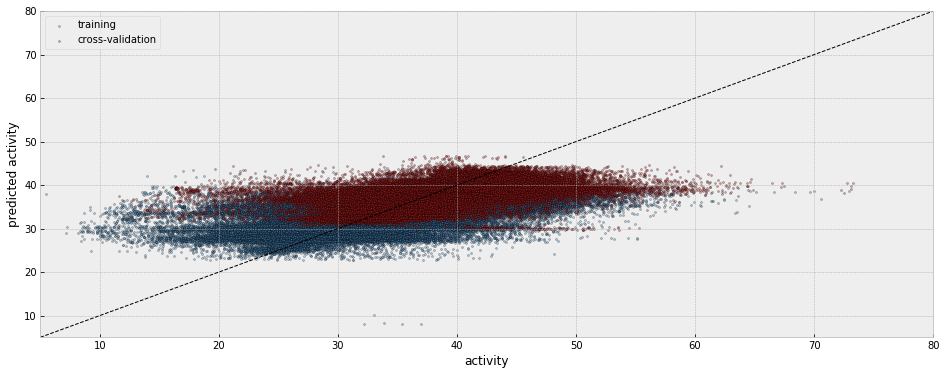

In [9]:
plt.scatter(tr_data.activity.values, tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data.activity.values, cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [0]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * y_trn.std() + y_trn.mean()

ts_preds = pd.DataFrame(ts_preds, columns=[TARGET], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv("activity_nn.csv")